# LeNet Tensorflow Implementation

In [0]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", reshape=False)
X_train, y_train           = mnist.train.images, mnist.train.labels
X_validation, y_validation = mnist.validation.images, mnist.validation.labels
X_test, y_test             = mnist.test.images, mnist.test.labels

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [0]:
print(f"Image Size: {X_train.shape[1:]}")
print(f"Training Set Samples: {X_train.shape[0]}")
print(f"Validation Set Samples: {X_validation.shape[0]}")
print(f"Test Set Samples: {X_test.shape[0]}")

Image Size: (28, 28, 1)
Training Set Samples: 55000
Validation Set Samples: 5000
Test Set Samples: 10000


0


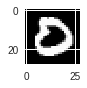

In [0]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image, cmap="gray")
print(y_train[index])

In [0]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

In [0]:
import tensorflow as tf

EPOCHS = 100
BATCH_SIZE = 128
LEARNING_RATE=0.001

In [0]:
def initialize_weights(shape, mean=0, stddev=0.1):
  initial_val = tf.truncated_normal(shape, mean=mean, stddev=stddev)
  return tf.Variable(initial_val, dtype=tf.float32)

def initialize_biases(shape, bias_val=0):
  initial_val = tf.constant(bias_val, shape=shape, dtype=tf.float32)
  return tf.Variable(initial_val, dtype=tf.float32)


def LeNet(X):
  with tf.name_scope("LeNet"):
    W_conv1 = initialize_weights(shape=(5,5,1,6))
    b_conv1 = initialize_biases(shape=[6])
    conv1 = tf.nn.conv2d(X, W_conv1, strides=[1, 1, 1, 1], padding='SAME') + b_conv1

    h_conv1 = tf.nn.relu(conv1)
    
    pool1 = tf.nn.max_pool(h_conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    W_conv2 = initialize_weights(shape=(5,5,6,16))
    b_conv2 = initialize_biases(shape=[16])
    conv2 = tf.nn.conv2d(pool1, W_conv2, strides=[1,1,1,1], padding='VALID')
    
    h_conv2 = tf.nn.relu(conv2)
    
    pool2 = tf.nn.max_pool(h_conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')

    fc0 = tf.layers.flatten(pool2, name='fc0') 
    
    W_fc1 = initialize_weights(shape=(400,120))
    b_fc1 = initialize_biases(shape=[120])
    fc1 = tf.matmul(fc0, W_fc1) + b_fc1
    
    h_fc1 = tf.nn.relu(fc1)
    
    W_fc2 = initialize_weights(shape=(120,84))
    b_fc2 = initialize_biases(shape=[84])
    fc2 = tf.matmul(h_fc1, W_fc2) + b_fc2
    
    h_fc2 = tf.nn.relu(fc2)
    
    W_fc3 = initialize_weights(shape=(84,10))
    b_fc3 = initialize_biases(shape=[10])
    logits = tf.matmul(h_fc2, W_fc3) + b_fc3
    
    return logits

In [0]:
def normalize_fixed(x, current_min, current_max, normed_min, normed_max):
    x_normed = (x - current_min) / (current_max - current_min)
    x_normed = x_normed * (normed_max - normed_min) + normed_min
    return x_normed

X = normalize_fixed(tf.placeholder(tf.float32, (None, 28, 28, 1)), 0, 255, -1, 1)
y = tf.placeholder(tf.int32, (None))

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).repeat(EPOCHS).batch(BATCH_SIZE)
iterator = train_dataset.make_initializable_iterator()
next_batch = iterator.get_next()

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
logits = LeNet(X)

with tf.name_scope("loss"):
  cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels=y, logits=logits)
  loss = tf.reduce_mean(cross_entropy)
  
with tf.name_scope("train"): 
  optimizer = tf.train.AdamOptimizer(learning_rate = LEARNING_RATE)
  training = optimizer.minimize(loss)
  
with tf.name_scope("eval"):
  accuracy = tf.metrics.accuracy(labels=y, predictions=tf.argmax(logits, axis=1))[1]

saver = tf.train.Saver()

In [0]:
with tf.Session() as sess:
  sess.run(tf.group(      
    tf.global_variables_initializer(),
    tf.local_variables_initializer(),
    iterator.initializer)
  )
  writer = tf.summary.FileWriter('./log', sess.graph)
  
  num_examples = len(X_train)
  new_accuracy = 0
  print("Training...")
  for i in range(EPOCHS):
    print("EPOCH {}: ".format(i+1))
    for offset in range(0, num_examples, BATCH_SIZE):
      end = offset + BATCH_SIZE
      batch_x, batch_y = X_train[offset:end], y_train[offset:end]
      sess.run(training, feed_dict={X: batch_x, y: batch_y})
      accuracy_ = sess.run(accuracy, {X: X_validation, y: y_validation})
      print("Validation Accuracy = {:.3f}".format(accuracy_))
      
    if accuracy_ > new_accuracy:
      new_accuracy = accuracy_
    elif accuracy_ < new_accuracy:
      print("Early Stopping")
      break
    saver.save(sess, './lenet.ckpt')
    print("Model saved")
  saver.save(sess, './lenet_final.ckpt')
  print('Final Model Saved')

In [32]:
with tf.Session() as sess:
    saver.restore(sess, './lenet_final.ckpt')
    sess.run(tf.local_variables_initializer())
    accuracy_ = sess.run(accuracy, {X: X_test, y: y_test})
    print("Test Accuracy = {:.3f}".format(accuracy_))

INFO:tensorflow:Restoring parameters from ./lenet_final.ckpt
Test Accuracy = 0.989
